# Fishers linear discriminant

See: https://scikit-learn.org/stable/modules/lda_qda.html

and https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import numpy as np
from ROOT import *
from array import array
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# For plot
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### (1) ROOT settings

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 

### (2) Define sample generation procedure

In [3]:
def mydata(Nmc,pos,sig,corr=0.0):

    data = np.empty(shape=(Nmc,2))
    
    phi = 0.5*asin(corr)

    g = np.random.normal(size=(2,Nmc))

    data[:,0] = pos[0] + sig[0]*(g[0]*cos(phi) + g[1]*sin(phi))
    data[:,1] = pos[1] + sig[1]*(g[0]*sin(phi) + g[1]*cos(phi))
    
    return data

### (3) Generating data

In [4]:
# Events per sample

Nmc = 50

# Measurement uncertainties

sig = np.array([1.2,0.6])
corr = 0.5

h1 = np.array([-1.,-1.])
h2 = np.array([1.,1.])


X = np.empty(shape=(2*Nmc,2))
y = np.empty(shape=(2*Nmc))


X[:Nmc,:] = mydata(Nmc,h1,sig,corr)
y[:Nmc] = -1

X[Nmc:,:] = mydata(Nmc,h2,sig,corr)
y[Nmc:] = 1

print("Test data defined, size: ",y.size)

Test data defined, size:  100


### (4) Calculate covariance matrix

In [5]:
acorr = np.array([[1.,corr],[corr,1.]])

cov = np.outer(sig,sig) * acorr

### (5) Calculate discriminant direction

In [6]:
cinv = np.linalg.inv(cov+cov)

w = cinv @ ( h2 - h1 )

norm = np.sum(w*w)

w /= sqrt(norm)

print("Coefficients: ",w[0],", ",w[1])

Coefficients:  3.9968028886505634e-17 ,  1.0


In [7]:
# Division line should cross in the middle between h1 and h2

h0 = 0.5*(h1+h2)

w0 = w @ h0

# Coefficients for the line    w @ h = w0

aw = -w[0]/w[1]
bw = w0/w[1]

print("Discriminant line: y = ",aw," * x  +  ",bw)

Discriminant line: y =  -3.9968028886505634e-17  * x  +   0.0


### (6) Linear discriminant from sklearn

In [8]:
# Create discriminant

clf = LinearDiscriminantAnalysis(solver="svd")    # ‘svd’, ‘lsqr’, 'eigen'
clf.fit(X, y)

# Check result (coefficients)

cf = clf.coef_[0]

# Normalise to unit vector (for comparison)

ncf = sqrt(np.sum(cf*cf))

print("Coefficients: ",cf[0]/ncf,", ",cf[1]/ncf)

# Check reference value at (0,0)

off = clf.predict_proba([[0.,0.]])

# Line to draw for p=0.5  ( y = a x + b )

a = -cf[0]/cf[1]
b = (0.5-off[0,0])/cf[1]

print("Discriminant line: y = ",a," * x  +  ",b)

Coefficients:  0.021195392989450144 ,  0.9997753524247448
Discriminant line: y =  -0.021200155552990155  * x  +   0.015006852238001613


### (7) Iterative approach

In [12]:
# Start from random weights and offset

wvec = 2.0*np.random.uniform(size=2)-1.0
wcut = 2.0*np.random.uniform()-1.0

nwv = sqrt(np.sum(wvec*wvec))
print("Initial coefficients: ",wvec[0]/nwv,", ",wvec[1]/nwv)
    

# Initial prediction

ypred  = np.tanh( (X @ wvec) - wcut) 
dy = ypred - y
dist = np.sum(dy*dy)
nok = np.sum(ypred*y > 0)

# Iteration starting step

eta = 0.01

it = 0
dmin = dist
print("Initial distance: ",sqrt(dist),", ",nok," events properly classified")

# Debug printout
# print(it,eta,wvec,wcut,nok,dist)
  
while True :

    it+=1
    
    dw = dy @ X

    cutnew = wcut + eta/Nmc * np.sum(dy)
    wnew = wvec - eta/Nmc * dw
    
    ypred  = np.tanh( (X @ wnew) - cutnew) 
    
    nok = np.sum(ypred*y > 0)

    dy = ypred - y
    dist = np.sum(dy*dy)

# Debug printout
#   print(it,eta,wnew,cutnew,nok,dist)
  
    if dist < dmin :
        wcut = cutnew
        wvec = wnew
        eta *= 2.0
        dmin = dist
    else:
        eta /= 2.
        
    if eta < 0.0000001 : break
    
    if nok == 2*Nmc : break
    
    if it == 1000 : break

  
# Normalized direction vector

nwv = sqrt(np.sum(wvec*wvec))

print(it," iterations, final distance: ",sqrt(dist),", ",nok," events properly classified")
print("Final coefficients: ",wvec[0]/nwv,", ",wvec[1]/nwv)
    
ai = -wvec[0]/wvec[1]
bi = wcut/wvec[1]

print("Discriminant line: y = ",ai," * x  +  ",bi)

Initial coefficients:  0.939753329383109 ,  -0.341853301744128
Initial distance:  11.251469455089403 ,  50  events properly classified
53  iterations, final distance:  4.4358023867489464 ,  94  events properly classified
Final coefficients:  -0.008593787606188534 ,  0.9999630727254781
Discriminant line: y =  0.008594104963061774  * x  +   0.03317818058150588


### (8) Plot results

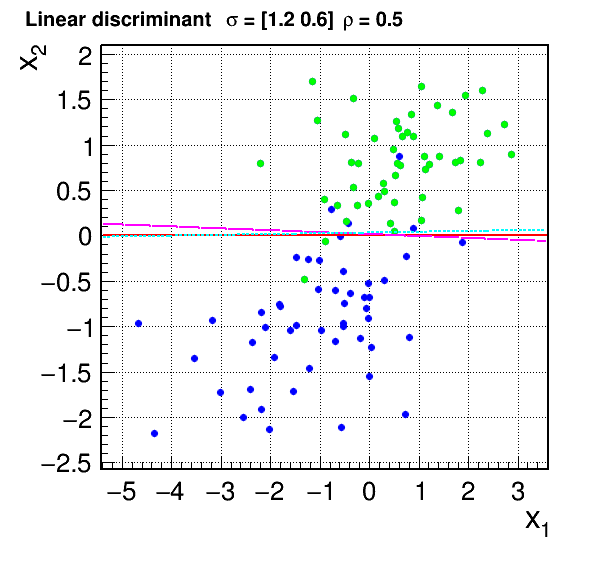

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cexp
Info in <TCanvas::Print>: png file 11_Fisher3_1.2_0.6_0.5.png has been created


In [13]:
# Square plot

gStyle.SetCanvasDefH(600)
 
# Create plot canvas

cexp = TCanvas('cexp')
   
# Create data graph

rgr = TGraph(y.size,array('d',X[:,0]),array('d',X[:,1]))

# Set graph options

rgr.SetNameTitle("rgr","Linear discriminant   #sigma = "+str(sig)+"  #rho = "+str(corr))
rgr.SetMarkerStyle(20)
rgr.SetMarkerSize(0.8)
rgr.SetMarkerColor(4)

rgr.GetXaxis().SetTitle("x_{1}")
rgr.GetYaxis().SetTitle("x_{2}")

# One of the sets

n1 = np.sum(y==1)

X1 = np.zeros(shape=(n1,2))

ip1 = 0
for ip in range(y.size):
    if y[ip]==1 :
        X1[ip1]=X[ip]
        ip1+=1
        


        
rgr1 = TGraph(int(n1),array('d',X1[:,0]),array('d',X1[:,1]))

# Set graph options

rgr1.SetNameTitle("rgr1","Test data")
rgr1.SetMarkerStyle(20)
rgr1.SetMarkerSize(0.8)
rgr1.SetMarkerColor(3)
    
# Line found from covariance

ldw = TF1("ldw","pol1",-10.,10.,2)
ldw.SetParameters(bw,aw)
ldw.SetLineStyle(1)
ldw.SetLineColor(2)

# Line found by sklearn

ldl = TF1("ldl","pol1",-10.,10.,2)
ldl.SetParameters(b,a)
ldl.SetLineStyle(7)
ldl.SetLineColor(6)

# Line found by iteration

ldi = TF1("ldi","pol1",-10.,10.,2)
ldi.SetParameters(bi,ai)
ldi.SetLineStyle(2)
ldi.SetLineColor(7)

# Plot 

rgr.Draw('AWP')
rgr1.Draw('P')
ldw.Draw('same')
ldl.Draw('same')
ldi.Draw('same')

cexp.Update()

if Nmc == 50 :
    fname = '11_Fisher3_'+str(sig[0])+'_'+str(sig[1])+'_'+str(corr)+'.png'
else :
    fname = '11_Fisher3_'+str(sig[0])+'_'+str(sig[1])+'_'+str(corr)+'_'+str(2*Nmc)+'.png'
    
cexp.Print(fname)

Image(filename=fname)